In [1]:
#loading libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#functions has been created so that i dont have to repeat the process for both stocks
#to load the data for last 10 years
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close'].values.reshape(-1, 1)
def create_sequences(data, seq_length):
    seq_list = []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        seq_list.append(seq)
    return np.array(seq_list)


In [3]:
# ADF test to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")



In [4]:
# If not stationary, perform differencing
def plot_acf_pacf(training_set):
  data_diff = pd.Series(training_set.flatten()).diff(1).dropna()
  # data_diff_diff = data_diff.diff(1).dropna()
  plt.figure(figsize=(12, 6))
  plt.plot(data_diff, label="Differenced Data")
  plt.title("Differenced Time Series")
  plt.legend()
  plt.show()
  check_stationarity(data_diff)
#ACF and PACF Plots
  plot_acf(data_diff, lags=20)
  plt.title("ACF Plot")
  plt.show()

  plot_pacf(data_diff, lags=20)
  plt.title("PACF Plot")
  plt.show()


In [5]:

#function to train the model using LSTM
def train_model(dataset, stock_name):
    #splitting data
    train_size = int(len(dataset) * 0.9833)
    train_data = dataset[:train_size]
    test_data = dataset[train_size:]
    # #scaling
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # train_scaled = scaler.fit_transform(train_data)
    # test_scaled = scaler.transform(test_data)

    #applying ARIMA model to stationary data
    print(f"\nFitting ARIMA model for {stock_name}...")
    arima_model = ARIMA(train_data, order=(1,1,1))
    arima_fit = arima_model.fit()
     #to get the residuals from arima prediction
    arima_predictions_train = arima_fit.predict(start=0, end=len(train_data)-2)
    arima_residuals = train_data[1:].flatten() - arima_predictions_train

    #to prepare LSTM data
    seq_length = 10
    X_train = create_sequences(arima_residuals, seq_length)
    y_train = arima_residuals[seq_length:]
    X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
     #create and train LSTM model
    print(f"Training LSTM model for {stock_name}...")
    lstm_model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(64, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
     #forecasting
    print(f"Generating forecasts for {stock_name}...")
    arima_forecast = arima_fit.forecast(steps=len(test_data))

    #prepare last sequence for LSTM prediction
    last_sequence = arima_residuals[-seq_length:]
    X_test = last_sequence.reshape(1, seq_length, 1)
    lstm_forecast = []
    #generate LSTM predictions
    for i in range(len(test_data)):
        lstm_pred = lstm_model.predict(X_test, verbose=0)
        lstm_forecast.append(lstm_pred[0,0])
        X_test = np.roll(X_test, -1)
        X_test[0, -1, 0] = lstm_pred[0,0]

    lstm_forecast = np.array(lstm_forecast)

    #combine predictions
    final_predictions = arima_forecast + lstm_forecast

    return test_data, final_predictions.reshape(-1,1), train_size

In [6]:
def plot_pred(stock_data, test_data, predictions, train_size, stock_name):
    plt.figure(figsize=(15, 7))
    plt.plot(range(train_size, len(stock_data)), test_data, label='Actual Values', color='blue')
    plt.plot(range(train_size, len(stock_data)), predictions, label='Hybrid Forecast', color='red', linestyle='dashed')
    plt.title(f'{stock_name} Stock Price: Hybrid ARIMA-LSTM Forecast vs Actual Values')
    plt.xlabel('Trading Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
def print_metrics(actual, predicted, stock_name, train_data):
    # Calculate RMSE
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)

    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)

    # Calculate MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Calculate MASE
    mae_test = np.mean(np.abs(actual - predicted))
    naive_forecast = np.mean(np.abs(np.diff(train_data)))
    mase = mae_test / naive_forecast

    print(f'\nPerformance Metrics for {stock_name}:')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Mean Absolute Scaled Error (MASE): {mase:.2f}')


/tmp/ipython-input-2-3630803380.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-3630803380.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


ADF Statistic: 0.42487657133699996
p-value: 0.9824017741350621
The series is not stationary.
ADF Statistic: 0.4091958663410271
p-value: 0.9818355953123817
The series is not stationary.


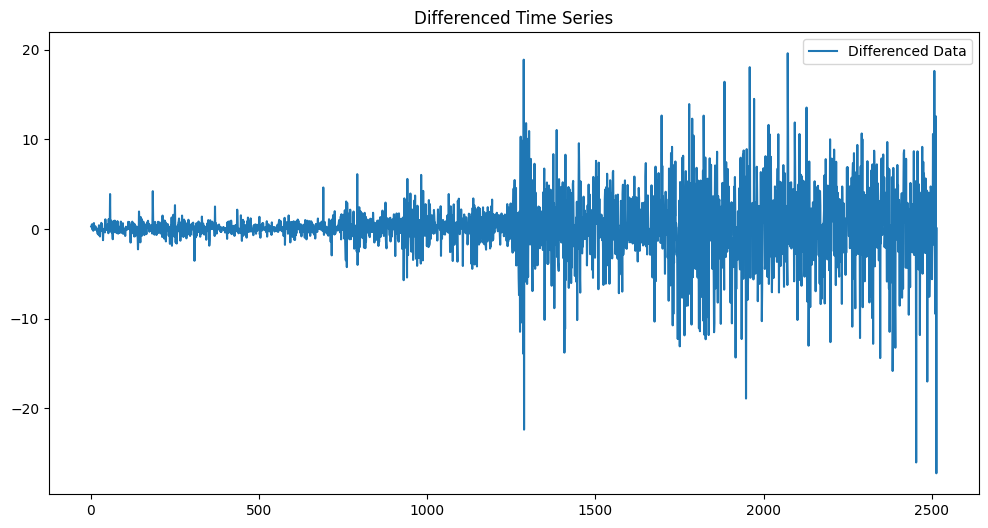

ADF Statistic: -13.817102140757477
p-value: 8.03113300249722e-26
The series is stationary.


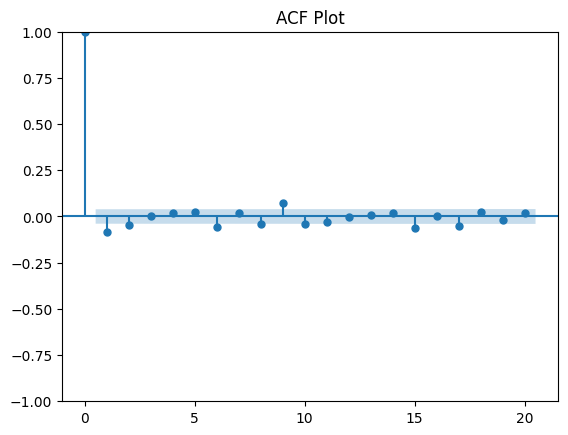

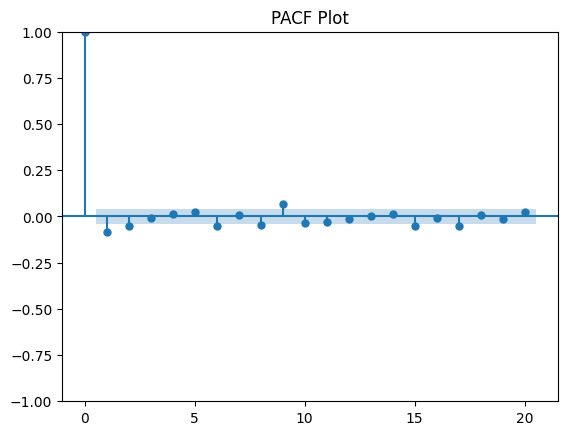

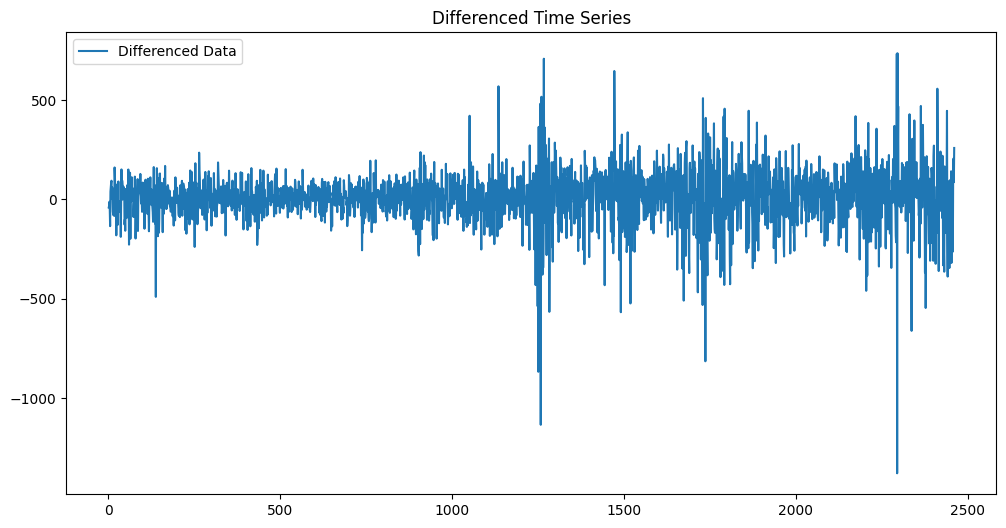

ADF Statistic: -20.50300001822781
p-value: 0.0
The series is stationary.


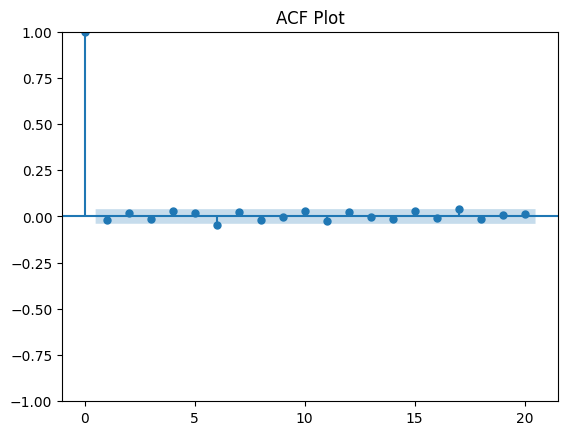

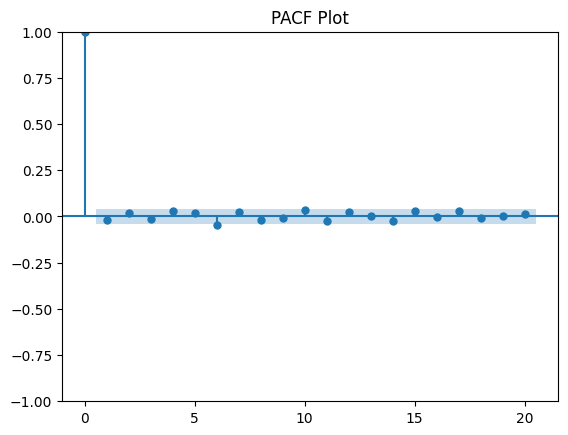


Fitting ARIMA model for Microsoft...
Training LSTM model for Microsoft...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generating forecasts for Microsoft...

Fitting ARIMA model for NIFTY 50...
Training LSTM model for NIFTY 50...
Generating forecasts for NIFTY 50...


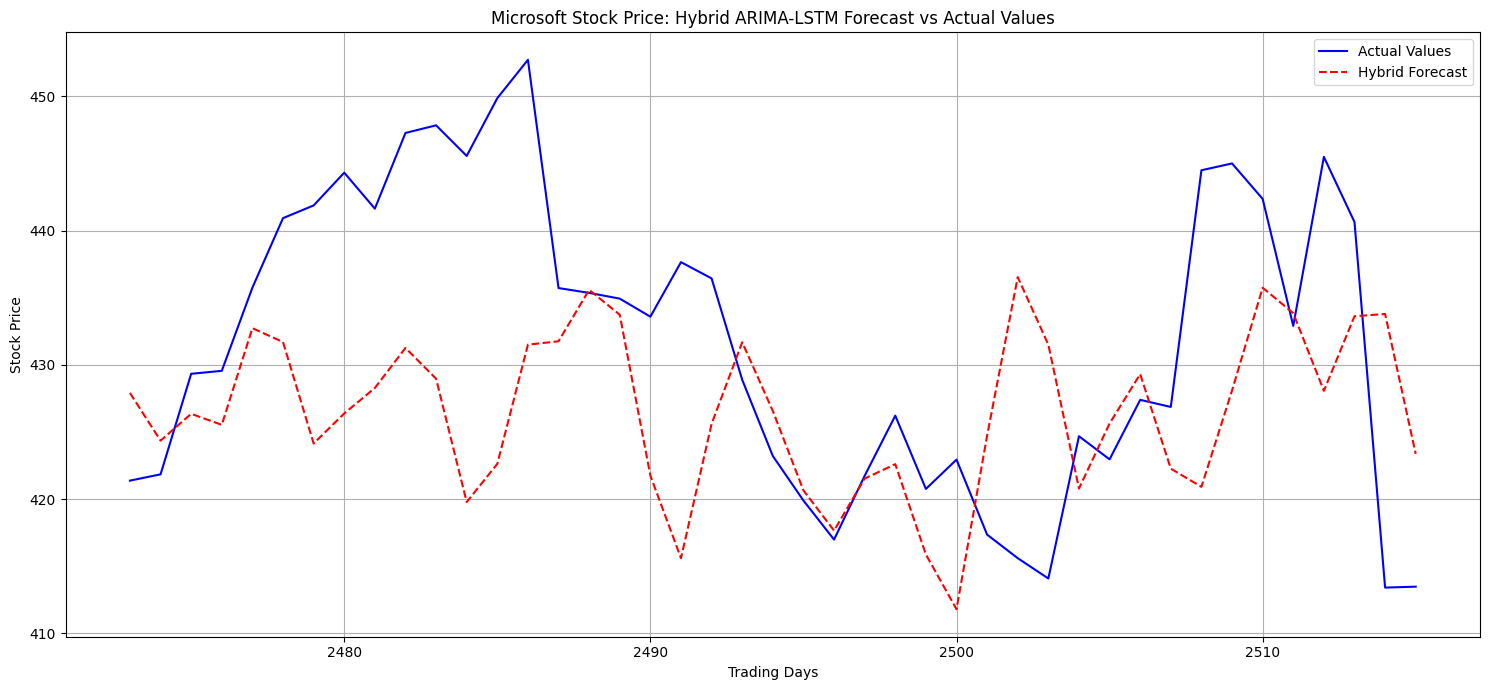

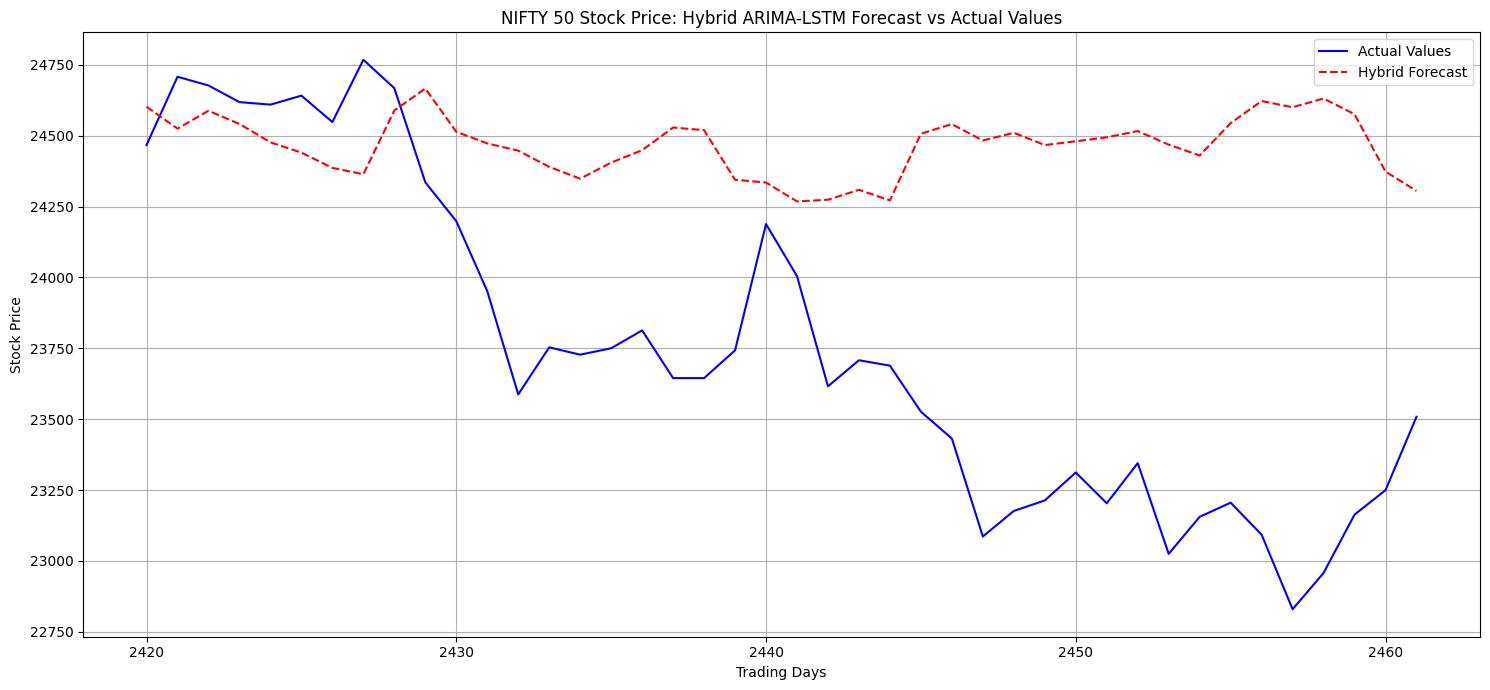


Performance Metrics for Microsoft:
Root Mean Squared Error (RMSE): 12.75
Mean Absolute Percentage Error (MAPE): 2.27%
Mean Absolute Scaled Error (MASE): nan

Performance Metrics for NIFTY 50:
Root Mean Squared Error (RMSE): 924.52
Mean Absolute Percentage Error (MAPE): 3.33%
Mean Absolute Scaled Error (MASE): nan


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
# main code
start_date = '2015-02-01'
end_date = '2025-02-01'

msft_data = load_data('MSFT',start_date,end_date)
nifty_data = load_data('^NSEI',start_date,end_date)

check_stationarity(msft_data)
check_stationarity(nifty_data)

plot_acf_pacf(msft_data)
plot_acf_pacf(nifty_data)
msft_test, msft_pred, msft_train_size = train_model(msft_data,'Microsoft')
nifty_test, nifty_pred, nifty_train_size = train_model(nifty_data,'NIFTY 50')
plot_pred(msft_data, msft_test, msft_pred, msft_train_size,'Microsoft')
plot_pred(nifty_data, nifty_test, nifty_pred, nifty_train_size,'NIFTY 50')
print_metrics(msft_test, msft_pred,'Microsoft',msft_data[:msft_train_size])
print_metrics(nifty_test, nifty_pred,'NIFTY 50',nifty_data[:nifty_train_size])